# 评估AFNONet的预报技巧

这个notebook用于评估UNet的预报技巧。

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
# Depending on your combination of package versions, this can raise a lot of TF warnings... 
import numpy as np
import matplotlib.pyplot as plt
import xarray as xr
import torch
import seaborn as sns
import pickle
import sys
sys.path.append('../')
from src.utils.score import *
from src.utils.plot import plot_iter_result
from collections import OrderedDict

In [3]:
device = device = torch.cuda.current_device() if torch.cuda.is_available() else 'cpu'

In [4]:
sns.set_style('darkgrid')
sns.set_context('notebook')

In [5]:
DATADIR = '../../geopotential_500/test'

## 读取预测数据集

从.nc文件中读取数据，为后续预测技巧的验证提供基础数据支撑

In [6]:
# Load the validation subset of the data: 2017 and 2018
# 读取4个小时的数据对代码进行debug
z500_valid = load_test_data(f'{DATADIR}', 'z', years=slice('2018'))
valid = xr.merge([z500_valid])
valid

<xarray.Dataset>
Dimensions:  (lat: 32, lon: 64, time: 8760)
Coordinates:
  * lat      (lat) float64 -87.19 -81.56 -75.94 -70.31 ... 75.94 81.56 87.19
    level    int32 ...
  * lon      (lon) float64 0.0 5.625 11.25 16.88 ... 337.5 343.1 348.8 354.4
  * time     (time) datetime64[ns] 2018-01-01 ... 2018-12-31T23:00:00
Data variables:
    z        (time, lat, lon) float32 dask.array<chunksize=(8760, 32, 64), meta=np.ndarray>
Attributes:
    units:          m**2 s**-2
    long_name:      Geopotential
    standard_name:  geopotential

In [7]:
from pathlib import Path

with open(Path('../../geopotential_500')/f'scaler.pkl', 'rb') as f:
    item = pickle.load(f)
    lon = item['lon']
    lat = item['lat']
    mean = item['mean']
    std = item['std']
    f.close()

mean, std

(54108.31062925485, 3352.3980519318557)

## 加载训练好的模型参数

In [8]:
from src.models.prednn_module import PredNNLitModule
afnonets = {}
# 1小时步长
module = PredNNLitModule.load_from_checkpoint('../../weights/pretrain/best_lead1h.ckpt')
afnonets['1'] = module.net.to(device).eval()
# 3小时步长
module = PredNNLitModule.load_from_checkpoint('../../weights/pretrain/best_lead3h.ckpt')
afnonets['3'] = module.net.to(device).eval()
# 6小时步长
module = PredNNLitModule.load_from_checkpoint('../../weights/pretrain/best_lead6h.ckpt')
afnonets['6'] = module.net.to(device).eval()
# 12小时步长
module = PredNNLitModule.load_from_checkpoint('../../weights/pretrain/best_lead12h.ckpt')
afnonets['12'] = module.net.to(device).eval()
# 24小时步长
module = PredNNLitModule.load_from_checkpoint('../../weights/pretrain/best_lead24h.ckpt')
afnonets['24'] = module.net.to(device).eval()

/public/home/wangwuxing01/.conda/envs/afnonet-core/lib/python3.8/site-packages/pytorch_lightning/utilities/parsing.py:268: UserWarning: Attribute 'net' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['net'])`.
  rank_zero_warn(


## 构建预报结果

使用AFNONet做预测，将预测结果写入nc文件中

In [9]:
fcs = []
preds = np.zeros(valid['z'].values.shape)
preds.shape

(8760, 32, 64)

In [10]:
dt = 1
prediction_length = 1 + (24 * 7) // dt
prediction_type = 'iterative'
n_initial_conditions = 5
DECORRELATION_TIME = 36

In [11]:
n_samples_per_year = len(valid['z'])//dt
n_samples = n_samples_per_year - prediction_length
stop = n_samples
ics = np.arange(0, stop, DECORRELATION_TIME)
n_ics = len(ics)

valid_loss = []
acc = []
seq_pred = []
seq_real = []

In [12]:
def gaussian_perturb(x, level=0.01, device=0):
    noise = level * torch.randn(x.shape).to(device, dtype=torch.float)
    return x + noise

In [13]:
def autoregressive_inference(ic, valid_data_full, model, dt, prediction_length):
    ic = int(ic)
    device = device = torch.cuda.current_device() if torch.cuda.is_available() else 'cpu'
    model = model.to(device)
    dt = dt
    prediction_length = int(prediction_length)
    clim = torch.from_numpy(valid_data_full.mean('time')['z'].values).to(device, dtype=torch.float)
    
    valid_loss = torch.zeros((prediction_length, 1)).to(device, dtype=torch.float)
    acc = torch.zeros((prediction_length, 1)).to(device, dtype=torch.float)
    seq_real = torch.zeros((prediction_length, 1, 32, 64)).to(device, dtype=torch.float)
    seq_pred = torch.zeros((prediction_length, 1, 32, 64)).to(device, dtype=torch.float)

    valid_data = valid_data_full['z'][ic:(ic+prediction_length*dt):dt].values #extract valid data from first year
    # standardize
    valid_data = (valid_data - mean)/std
    valid_data = torch.as_tensor(valid_data).to(device, dtype=torch.float)

    with torch.no_grad():
        for i in range(valid_data.shape[0]):
            # 从ic开始
            if i==0: #start of sequence
                first = valid_data[0]
                future = valid_data[1]
                seq_real[0] = first #extract history from 1st 
                seq_pred[0] = gaussian_perturb(first, level=0.01, device=device)
                future_pred = model(torch.unsqueeze(seq_pred[0], dim=0))
            else:
                # 存储下一时刻的真值
                if i < prediction_length-1:
                    future = valid_data[i+1]
                future_pred = model(future_pred) #autoregressive step
            
            if i < prediction_length-1: #not on the last step
                seq_pred[i+1] = future_pred
                seq_real[i+1] = future

            valid_loss[i] = compute_weighted_rmse(seq_pred[i], 
                                                  seq_real[i], 
                                                  torch.from_numpy(valid_data_full['lat'].values).to(device, dtype=float)) * std
            # print(valid_loss[i])
            acc[i] = compute_weighted_acc(seq_pred[i]*std+mean, 
                                        seq_real[i]*std+mean, 
                                        clim,
                                        torch.from_numpy(valid_data_full['lat'].values).to(device, dtype=float))
            
                         
        pred_nc = xr.DataArray(
            seq_pred.cpu().detach().numpy() * std + mean,
            dims=['lead_time', 'time', 'lat', 'lon'],
            coords={
                'lead_time': np.arange(0, prediction_length*dt, dt),
                'time': valid_data_full.time.values[ic:ic+1], 
                'lat': valid_data_full.lat.values, 
                'lon': valid_data_full.lon.values
            },
            name='z'
        )
        
    return pred_nc, np.expand_dims(valid_loss.cpu().numpy(), axis=0), np.expand_dims(acc.cpu().numpy(), axis=0)

In [14]:
fcs = []
val_rmse, val_acc = [], []
for i, ic in enumerate(ics):
    fc, rmse, acc = autoregressive_inference(ic, valid, afnonets['1'], dt, prediction_length)
    fcs.append(fc)
    val_rmse.append(rmse)
    val_acc.append(acc)

In [15]:
fc_iter = xr.merge(fcs)
val_rmse = np.mean(np.concatenate(val_rmse, 0), axis=0)
val_acc = np.mean(np.concatenate(val_acc, 0), axis=0)

In [16]:
xr_rmse = [xr.DataArray(
                        val_rmse[:,0],
                        dims=['Lead Time'],
                        coords={
                            'Lead Time': fc_iter.lead_time.values,
                        },
                        name='z'
                    )]
xr_rmse = xr.merge(xr_rmse)

In [17]:
xr_rmse

<xarray.Dataset>
Dimensions:    (Lead Time: 169)
Coordinates:
  * Lead Time  (Lead Time) int64 0 1 2 3 4 5 6 7 ... 162 163 164 165 166 167 168
Data variables:
    z          (Lead Time) float32 33.46 42.61 54.21 ... 2.024e+03 2.041e+03

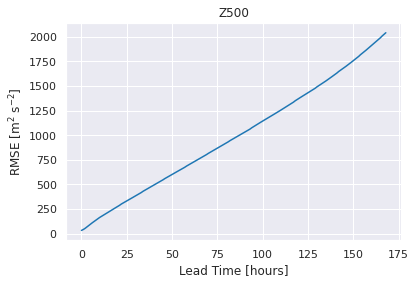

In [18]:
plot_iter_result(xr_rmse, 'z', 'Lead Time', 'RMSE', 'Z500', ' [hours]', ' [m$^2$ s$^{-2}$]')

In [19]:
xr_acc = [xr.DataArray(
                        val_acc[:,0],
                        dims=['Lead Time'],
                        coords={
                            'Lead Time': fc_iter.lead_time.values,
                        },
                        name='z'
                    )]
xr_acc = xr.merge(xr_acc)

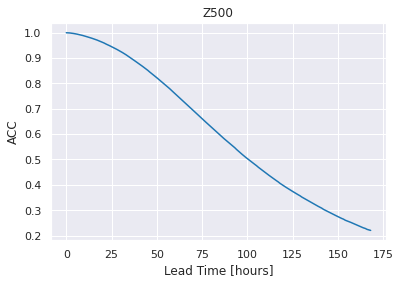

In [20]:
plot_iter_result(xr_acc, 'z', 'Lead Time', 'ACC', 'Z500', ' [hours]', '')

/tmp/ipykernel_184351/2158279542.py:21: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  cb = fig.colorbar(I, ax=ax, orientation='horizontal', pad=0.01, shrink=0.90)
/tmp/ipykernel_184351/2158279542.py:21: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  cb = fig.colorbar(I, ax=ax, orientation='horizontal', pad=0.01, shrink=0.90)
/tmp/ipykernel_184351/2158279542.py:21: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  cb = fig.colorbar(I, ax=ax, orientation='horizontal', pad=0.01, shrink=0.90)
/tmp/ipykernel_184351/2158279542.py:21: MatplotlibDeprecationWarning: Auto-removal of grids by pc

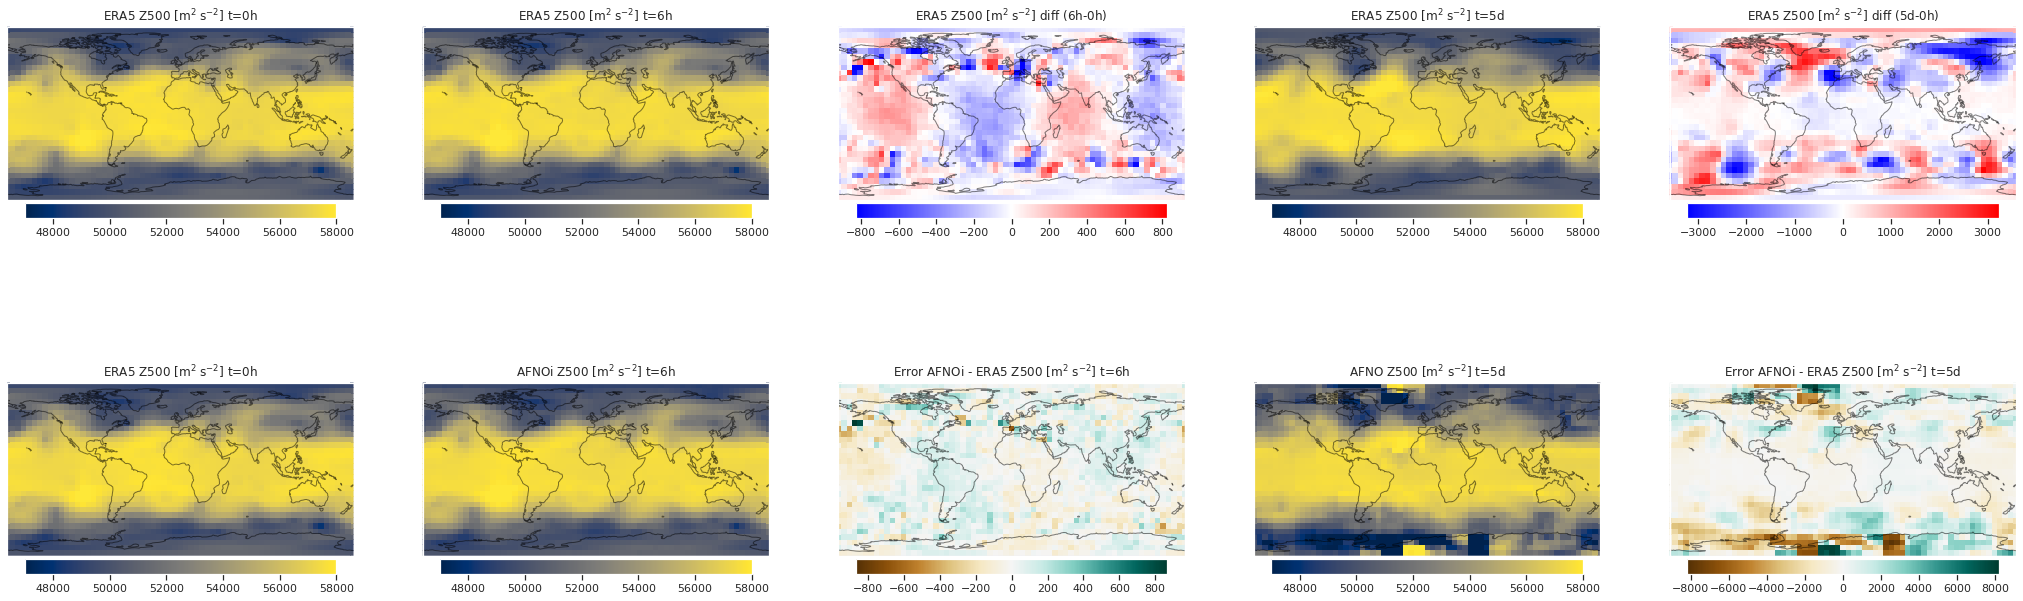

In [21]:
import matplotlib
import matplotlib.pyplot as plt
import cartopy
from os.path import expanduser
# cartopy.config['repo_data_dir'] = expanduser('/public/home/wangwuxing01/cartopy/natural-earth-vector-5.1.2/')
# cartopy.config['data_dir'] = expanduser('/public/home/wangwuxing01/cartopy/natural-earth-vector-5.1.2/')
import cartopy.crs as ccrs

cmap_z = 'cividis'
cmap_t = 'RdYlBu_r'
cmap_diff = 'bwr'
cmap_error = 'BrBG'

def imcol(ax, data, title='', **kwargs):
    if not 'vmin' in kwargs.keys():
        mx = np.abs(data.max().values)
        kwargs['vmin'] = -mx; kwargs['vmax'] = mx
#     I = ax.imshow(data, origin='lower',  **kwargs)
    I = data.plot(ax=ax, transform=ccrs.PlateCarree(), add_colorbar=False, add_labels=False, 
                  rasterized=True, **kwargs)
    cb = fig.colorbar(I, ax=ax, orientation='horizontal', pad=0.01, shrink=0.90)
    ax.set_title(title)
    ax.coastlines(alpha=0.5)

fig, axs = plt.subplots(2, 5, figsize=(36, 12), subplot_kw={'projection': ccrs.PlateCarree()})
# True
for iax, var, cmap, r, t in zip(
    [0], ['z'], [cmap_z], [[47000, 58000]], [r'Z500 [m$^2$ s$^{-2}$]']):
    imcol(axs[iax,0], valid[var].isel(time=0), cmap=cmap, 
          vmin=r[0], vmax=r[1], title=f'ERA5 {t} t=0h')
    imcol(axs[iax,1], valid[var].isel(time=6), cmap=cmap, 
          vmin=r[0], vmax=r[1], title=f'ERA5 {t} t=6h')
    imcol(axs[iax,2],
        valid[var].isel(time=6)-valid[var].isel(time=0), cmap=cmap_diff, 
        title=f'ERA5 {t} diff (6h-0h)')
    imcol(axs[iax,3], valid[var].isel(time=5*24), cmap=cmap, 
          vmin=r[0], vmax=r[1], title=f'ERA5 {t} t=5d')
    imcol(axs[iax,4], 
        valid[var].isel(time=5*24)-valid[var].isel(time=0), cmap=cmap_diff, 
        title=f'ERA5 {t} diff (5d-0h)')

# AFNONet
for iax, var, cmap, r, t in zip(
    [1], ['z'], [cmap_z], [[47000, 58000]], [r'Z500 [m$^2$ s$^{-2}$]']):
    imcol(axs[iax,0], valid[var].isel(time=0), cmap=cmap, 
          vmin=r[0], vmax=r[1], title=f'ERA5 {t} t=0h')
    imcol(axs[iax,1], fc_iter[var].isel(time=0).sel(lead_time=6), cmap=cmap, 
          vmin=r[0], vmax=r[1], title=f'AFNOi {t} t=6h')
    imcol(axs[iax,2], 
        fc_iter[var].isel(time=0).sel(lead_time=6)-valid[var].isel(time=6), cmap=cmap_error,
        title=f'Error AFNOi - ERA5 {t} t=6h')
    imcol(axs[iax,3], fc_iter[var].isel(time=0).sel(lead_time=5*24), cmap=cmap, 
          vmin=r[0], vmax=r[1], title=f'AFNO {t} t=5d')
    imcol(axs[iax,4], 
        fc_iter[var].isel(time=0).sel(lead_time=5*24) - valid[var].isel(time=5*24), cmap=cmap_error,
        title=f'Error AFNOi - ERA5 {t} t=5d')